In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.feature import hog
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# Read in cars   
cars=[]
car_images = glob.glob('dataset/vehicles/**/*.png',recursive=True)
for image in car_images:
    cars.append(image)


In [3]:
# Read in notcars
notcars=[]
notcar_images = glob.glob('dataset/non-vehicles/**/*.png',recursive=True)
for image in notcar_images:
    notcars.append(image)

In [140]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    car_image = mpimg.imread(car_list[0])
    
    data_dict["image_shape"] = car_image.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = car_image.dtype
    # Return data_dict
    return data_dict


Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


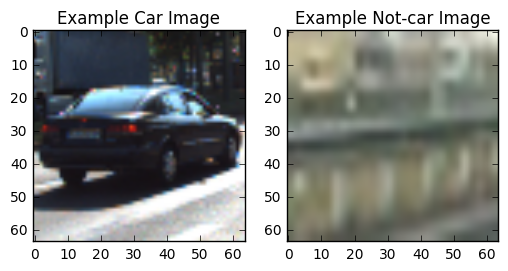

In [141]:
# Data Exploration
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

In [143]:
def plot(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        #plt.title(i+1)
        if len(img.shape) < 3:
            plt.imshow(img)
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])

In [4]:
# image space converter
def convert_image(image, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    return feature_image

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [ ]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
#hog_channel = 0 # Can be 0, 1, 2, or "ALL"
#spatial_size = (16, 16) # Spatial binning dimensions
#hist_bins = 16    # Number of histogram bins
#spatial_feat = True # Spatial features on or off
#hist_feat = True # Histogram features on or off
##hog_feat = True # HOG features on or off
#y_start_stop = [None, None] # Min and max in y to search in slide_window()

Exception ignored in: <bound method VideoFileClip.__del__ of <moviepy.video.io.VideoFileClip.VideoFileClip object at 0x7f98dbcd3390>>
Traceback (most recent call last):
  File "/home/prasad/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/moviepy/video/io/VideoFileClip.py", line 86, in __del__
    del self.reader
AttributeError: reader


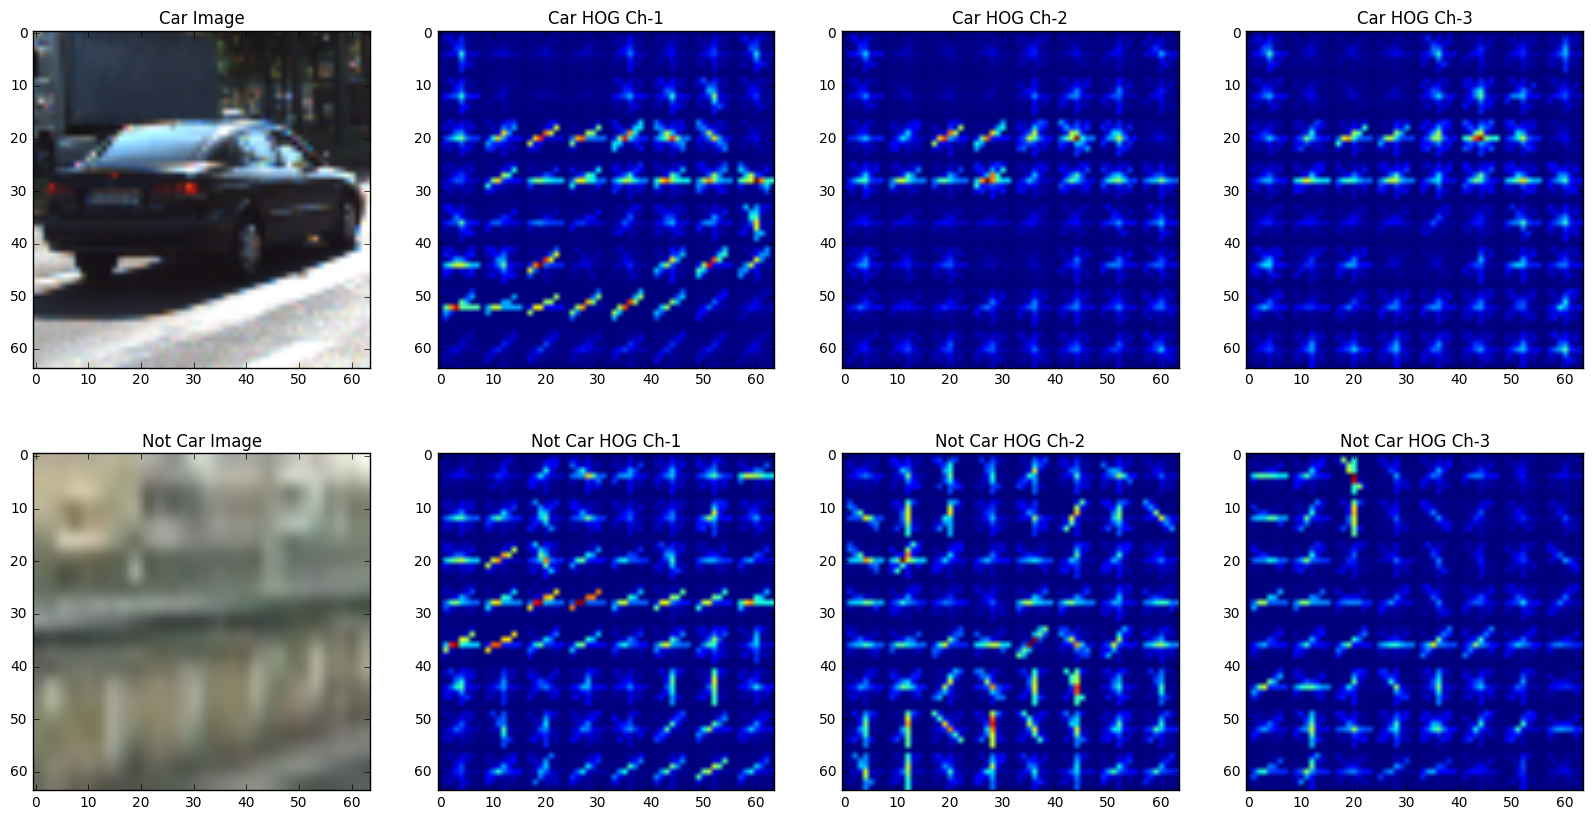

In [144]:
#Display HOG features
car_img_yuv = convert_image(car_image,'YUV')
notcar_img_yuv = convert_image(notcar_image,'YUV')

feat_car, hog_car1 = get_hog_features(car_img_yuv[:,:,0], orient,pix_per_cell,cell_per_block,vis=True)
feat_notcar, hog_notcar1 = get_hog_features(notcar_img_yuv[:,:,0], orient,pix_per_cell,cell_per_block,vis=True)
feat_car, hog_car2 = get_hog_features(car_img_yuv[:,:,1], orient,pix_per_cell,cell_per_block,vis=True)
feat_notcar, hog_notcar2 = get_hog_features(notcar_img_yuv[:,:,1], orient,pix_per_cell,cell_per_block,vis=True)
feat_car, hog_car3 = get_hog_features(car_img_yuv[:,:,2], orient,pix_per_cell,cell_per_block,vis=True)
feat_notcar, hog_notcar3 = get_hog_features(notcar_img_yuv[:,:,2], orient,pix_per_cell,cell_per_block,vis=True)

imgs = [car_image, hog_car1, hog_car2, hog_car3, notcar_image, hog_notcar1, hog_notcar2, hog_notcar3]
titles = ['Car Image', 'Car HOG Ch-1','Car HOG Ch-2','Car HOG Ch-3','Not Car Image', 
          'Not Car HOG Ch-1','Not Car HOG Ch-2','Not Car HOG Ch-3']
fig = plt.figure(figsize=(20,10))
plot(fig, 2, 4, imgs, titles)

In [6]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()


In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB',  img_type='JPG',spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        if img_type == 'PNG': # PNG images read by mpimg are in range 0-1. 
           image = (image*255).astype(np.uint8)
            #image = image.astype(np.float32)/255 # Need to be scaled to 0-1
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_image(image, color_space=color_space)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [10]:
#Model
car_features = extract_features(cars, color_space=color_space,img_type='PNG', 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, img_type='PNG',
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

#X_train, y_train = shuffle(X_train, y_train)
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 4704
21.35 Seconds to train SVC...
Test Accuracy of SVC =  0.9882
My SVC predicts:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  0.  0.  0.  1.  0.]
0.00545 Seconds to predict 10 labels with SVC


In [20]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                     xy_overlap=(0.8, 0.8)):
    # If x and/or y start/stop positions not defined, set to image size
    XY_WINDOWS = [(64,64),(96,96),(128,128)]
    #XY_WINDOWS = [(64,64),(128,128)]
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    window_list = []
    for xy_window in XY_WINDOWS:
        # Compute the number of pixels per step in x/y
        nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
        ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
        # Compute the number of windows in x/y
        nx_windows = np.int(xspan/nx_pix_per_step) - 1
        ny_windows = np.int(yspan/ny_pix_per_step) - 1
        # Initialize a list to append window positions to
    
        # Loop through finding x and y window positions
        # Note: you could vectorize this step, but in practice
        # you'll be considering windows one by one with your
        # classifier, so looping makes sense
        for ys in range(ny_windows):
            for xs in range(nx_windows):
            # Calculate window position
                startx = xs*nx_pix_per_step + x_start_stop[0]
                endx = startx + xy_window[0]
                starty = ys*ny_pix_per_step + y_start_stop[0]
                endy = starty + xy_window[1]
            
            # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

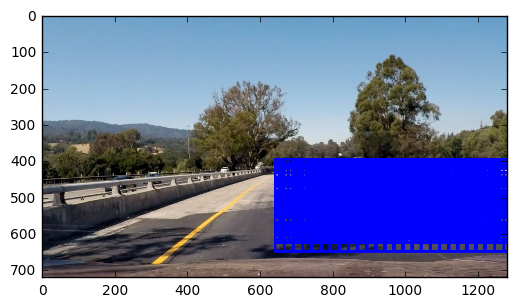

In [21]:
# Test slide windows
image = mpimg.imread('test_images/test4.jpg')
y_start_stop = [int(image.shape[0]*0.55), int(image.shape[0]*0.8)]
x_start_stop = [int(image.shape[1]/2), None]

windows = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                     xy_overlap=(0.8, 0.8))

img = draw_boxes(image, windows)
plt.imshow(img)

In [13]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_image(img, color_space=color_space)
    else: feature_image = np.copy(img)      
     
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [15]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
           on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

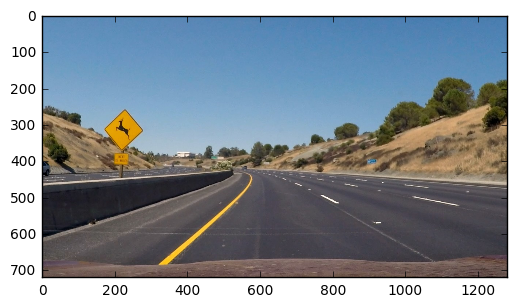

In [66]:
# Test search and classify 
image = mpimg.imread('test_images/test2.jpg')
y_start_stop = [int(image.shape[0]*0.55), int(image.shape[0]*0.8)]
x_start_stop = [int(image.shape[1]/2), None]

windows = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                     xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)      
img = draw_boxes(image, hot_windows)
plt.imshow(img)

In [117]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, heatmap):
    
    labels = label(heatmap)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        x_min, y_min, x_max, y_max = np.min(nonzerox), np.min(nonzeroy), np.max(nonzerox), np.max(nonzeroy)
        #if x_max - x_min > 40 and y_max - y_min > 40:
        # Define a bounding box based on min/max x and y
        bbox = ((x_min,y_min), (x_max,y_max))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
# Test search and classify 
    return img

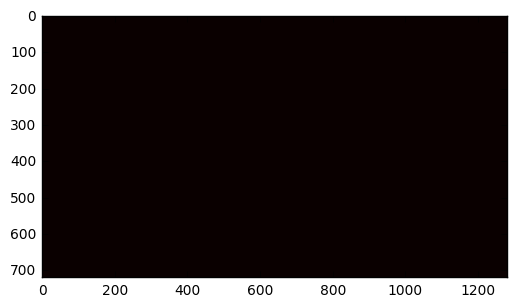

In [138]:
# Show heatmap
image = mpimg.imread('test_images/test2.jpg')
y_start_stop = [int(image.shape[0]*0.55), int(image.shape[0]*0.8)]
x_start_stop = [int(image.shape[1]/2), None]

windows = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                     xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
if len(hot_windows) > 0:
   heatmap = add_heat(heatmap, hot_windows)
   heatmap = apply_threshold(heatmap,3)

plt.imshow(heatmap, cmap='hot')


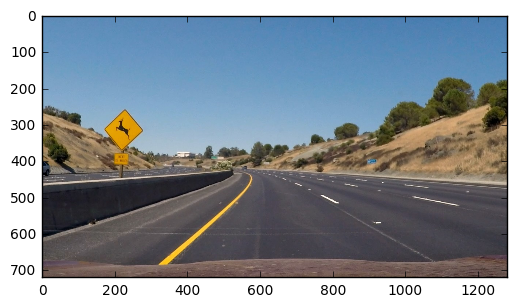

In [139]:
# draw boxes
img = draw_labeled_bboxes(image, heatmap)
plt.imshow(image)

In [114]:
def process_image(image):
    y_start_stop = [int(image.shape[0]*0.55), int(image.shape[0]*0.8)]
    x_start_stop = [int(image.shape[1]/2), None]

    windows = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                     xy_overlap=(0.8, 0.8))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, hot_windows)
    heatmap = apply_threshold(heatmap,3)
    img = draw_labeled_bboxes(image, heatmap)
    return img

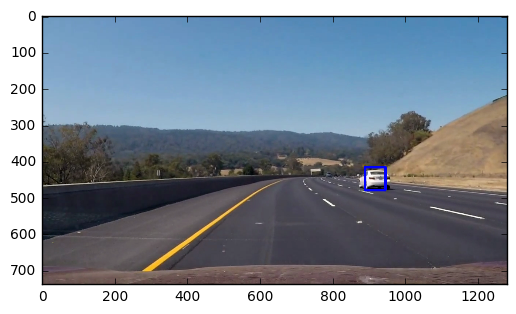

In [118]:
image = mpimg.imread("test_images/car2.png") 
image = (image*255).astype(np.uint8)
a = process_image(image)
plt.imshow(a)

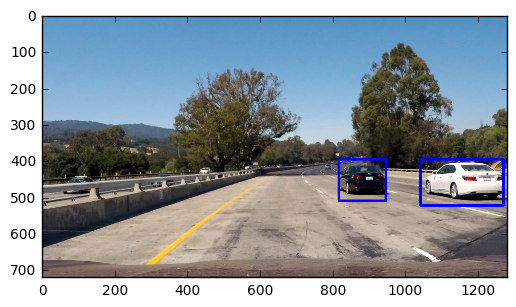

In [42]:
image = mpimg.imread("test_images/test1.jpg") 
a = process_image(image)
plt.imshow(a)

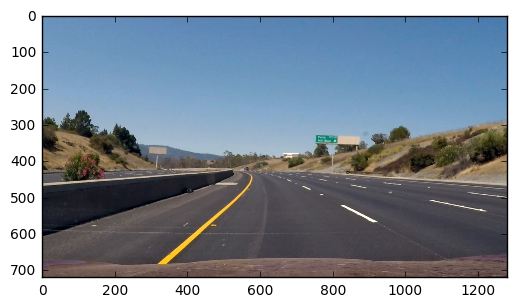

In [99]:
clip1 = VideoFileClip('project_video.mp4')
frame = process_image(clip1.get_frame(1011))
plt.imshow(frame)
plt.show()

In [121]:
#code cell 18
from moviepy.editor import VideoFileClip
video_output = 'testing_result.mp4'
clip1 = VideoFileClip("./testing.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video testing_result.mp4
[MoviePy] Writing video testing_result.mp4


 99%|█████████▉| 99/100 [15:07<00:08,  8.95s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: testing_result.mp4 



In [100]:
#code cell 18
from moviepy.editor import VideoFileClip
video_output = 'test_video_result.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video test_video_result.mp4
[MoviePy] Writing video test_video_result.mp4



 97%|█████████▋| 38/39 [06:13<00:09,  9.51s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_result.mp4 



In [122]:
#code cell 18
from moviepy.editor import VideoFileClip
video_output = 'result_submission.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video result_submission.mp4
[MoviePy] Writing video result_submission.mp4


100%|█████████▉| 1260/1261 [3:11:32<00:09,  9.09s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_submission.mp4 



In [123]:
frame_count=5

class Vehicle_Detected:
   def __init__(self):
        self.framecount = 0
        self.hot_windows=[]
        
   def add_hotwindows(self,hot_windows):
        self.hot_windows.append(hot_windows)
        self.hot_windows= self.hot_windows[-frame_count:]
        
   def heatmap(self):
        heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
        for windows in self.hot_windows:
            heatmap = add_heat(heatmap, windows)
        heatmap = apply_threshold(heatmap,3)
        return heatmap   

In [124]:
def process_image(image,detected=None):
    if detected is None:
        detected = Vehicle_Detected()
    y_start_stop = [int(image.shape[0]*0.55), int(image.shape[0]*0.8)]
    x_start_stop = [int(image.shape[1]/2), None]

    windows = slide_windows(image, x_start_stop=x_start_stop, y_start_stop=y_start_stop, 
                     xy_overlap=(0.8, 0.8))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
    
    
    detected.framecount+=1
    detected.add_hotwindows(hot_windows)
    heatmap = detected.heatmap()
    
    img = draw_labeled_bboxes(image, heatmap)
    return img
  

In [125]:
movie_output = 'result_smoothing.mp4'
detected = Vehicle_Detected()
clip1 = VideoFileClip("./project_video.mp4", audio=False)
white_clip = clip1.fl_image(lambda img: process_image(img,detected=detected))
white_clip.write_videofile(movie_output, audio = False)

[MoviePy] >>>> Building video result_smoothing.mp4
[MoviePy] Writing video result_smoothing.mp4


100%|█████████▉| 1260/1261 [3:12:25<00:09,  9.11s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_smoothing.mp4 

